In [19]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu = 0

weight_cliping_limit = 0.01

device = torch.device("cpu")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

dataset = dset.MNIST('./mnist', train=True, download=True, transform=transform)

In [3]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

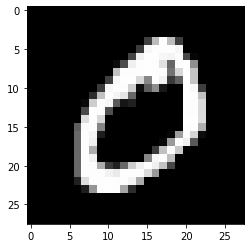

In [4]:
plt.imshow(dataset[1][0].reshape(28,28), cmap='Greys_r')

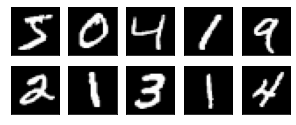

In [5]:


fig = plt.figure(figsize=(5,2))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(dataset[i][0].reshape(28, 28), cmap='Greys_r')

In [6]:
dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2,ngf,4,2,2,bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [9]:
netG = Generator().to(device)
netG.apply(weights_init)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf*1,ndf*2,4,2,2,bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace= True),

            nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace= True),

            nn.Conv2d(ndf*4,1,4,1,0,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
netD = Discriminator().to(device)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [12]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64,nz,1,1, device=device)

fake_label = -1.0
real_label = 1.0

flabels = torch.full((batch_size,),fake_label,dtype=torch.float,device=device)
rlabels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

optG = torch.optim.Adam(netG.parameters(),lr = 2*lr, betas=(beta1,0.999))
optD = torch.optim.Adam(netD.parameters(), lr = lr, betas=(beta1,0.999))


In [13]:
img_list = []
D_losses = []
G_losses = []

iters = 0

one = torch.FloatTensor([1])
mone = one * -1

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader):
        netD.zero_grad()

        for p in netD.parameters():
            p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)

        real_pics = data[0].to(device)

        b_size = real_pics.size(0)

        rlabels = 0.2*torch.randn((b_size,), dtype= torch.float, device=device) + torch.ones((b_size,), dtype=torch.float, device=device)
        flabels = 0.2*torch.randn((b_size,), dtype= torch.float, device=device) - torch.ones((b_size,), dtype=torch.float, device=device)

        out_D_real = netD(real_pics)
        D_x = out_D_real.mean().item()
        lossDr = out_D_real.mean(0).view(1)
        lossDr.backward(one)

        noise = torch.randn((b_size,nz,1,1), dtype=torch.float, device=device)
        generated_pics = netG(noise)

        lossDf = netD(generated_pics.detach())
        D_G_z1 = lossDf.mean().item()
        lossDf = lossDf.mean(0).view(1)
        lossDf.backward(mone)
        lossD = lossDr - lossDf
        optD.step()

        if i%5==0:
            netG.zero_grad()

            lossG = netD(generated_pics)
            D_G_z2 = lossG.mean().item()
            lossG = lossG.mean(0).view(1)
            lossG.backward(one)
            optG.step()

        if iters%10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, iter: {iters}/{len(dataloader)},\nlossD_fake: {lossDf.item()}, lossD_real: {lossDr.item()} lossG: {lossG.item()},\nD(x): {D_x}, D(G(z)): {D_G_z1}/{D_G_z2}")
            G_losses.append(lossG.item())
            D_losses.append(lossD.item())

            if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

epoch: 0/5, iter: 0/469,
lossD_fake: 0.49989497661590576, lossD_real: 0.5000466704368591 lossG: 0.49999311566352844,
D(x): 0.5000466704368591, D(G(z)): 0.49989497661590576/0.49999311566352844
epoch: 0/5, iter: 10/469,
lossD_fake: 0.49813148379325867, lossD_real: 0.47418463230133057 lossG: 0.49950647354125977,
D(x): 0.47418463230133057, D(G(z)): 0.49813148379325867/0.49950647354125977
epoch: 0/5, iter: 20/469,
lossD_fake: 0.5102742314338684, lossD_real: 0.46313586831092834 lossG: 0.5162706971168518,
D(x): 0.46313586831092834, D(G(z)): 0.5102742314338684/0.5162706971168518
epoch: 0/5, iter: 30/469,
lossD_fake: 0.5361286401748657, lossD_real: 0.4507647156715393 lossG: 0.5422111749649048,
D(x): 0.4507647156715393, D(G(z)): 0.5361286401748657/0.5422111749649048
epoch: 0/5, iter: 40/469,
lossD_fake: 0.5512287616729736, lossD_real: 0.44331666827201843 lossG: 0.5575048327445984,
D(x): 0.44331666827201843, D(G(z)): 0.5512287616729736/0.5575048327445984
epoch: 0/5, iter: 50/469,
lossD_fake: 0.56

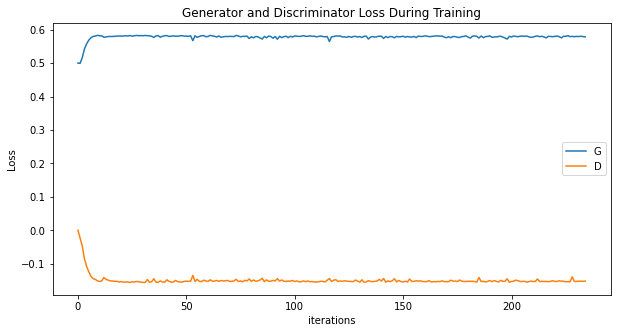

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

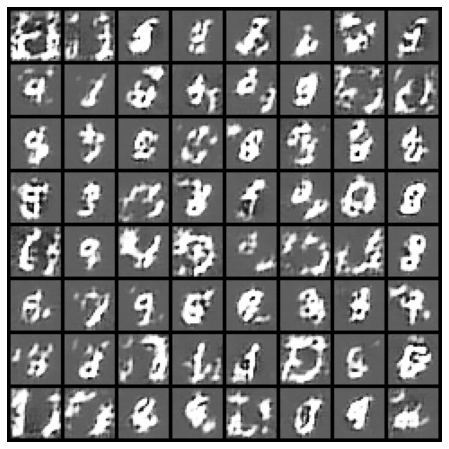

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [20]:
fake = netG(fixed_noise).detach().cpu()

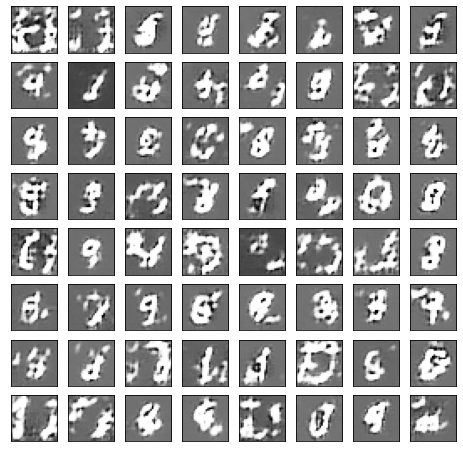

In [23]:

fig = plt.figure(figsize=(8,8))
for i in range(64):
    ax = fig.add_subplot(8,8, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(fake[i].reshape(28, 28), cmap='Greys_r')

In [18]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(fake,(1,2,0)))


torch.Size([3, 242, 242])
